## Train Model

In [1]:
import os
import logging
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

from SimpleWalk2D import SimpleWalk2DDynGoal

env = SimpleWalk2DDynGoal()

### Train Callback

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

### Optuna


In [ ]:
import os
import optuna

# Function to return test hyperparameters - define the object function

LOG_DIR = './logs/'
OPT_DIR = './opt/'

def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 2048, 8192),
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99)
    }
    
SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

# Run a training loop and return mean reward 
def optimize_agent(trial):
    try:
        model_params = optimize_ppo(trial) 

        # Create environment 
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Create algo 
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params)
        model.learn(total_timesteps=30000)
        #model.learn(total_timesteps=100000)

        # Evaluate model 
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    except Exception as e:
        return -1000
    
# Creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=10, n_jobs=1)
#study.optimize(optimize_agent, n_trials=100, n_jobs=1)

study.best_params

study.best_trial

model = PPO.load(os.path.join(OPT_DIR, 'trial_5_best_model.zip'))


In [3]:
env_name = 'SW2DDynGoal'

CHECKPOINT_DIR = './train/train_' + env_name
LOG_DIR = './train/log_' + env_name

callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

log_path = os.path.join('Training', 'Logs')

model = PPO(
    "MlpPolicy", 
    env, 
    verbose=0, 
    tensorboard_log=log_path,
    #learning_rate=0.0001,
    #n_steps =2048
    )
logger.setLevel(logging.INFO)

model.learn(
    total_timesteps=300_000, 
    callback = callback
    )

model.save('PPO')

logger.setLevel(logging.DEBUG)

## Test Model

In [4]:
from stable_baselines3 import PPO
from SimpleWalk2D import SimpleWalk2DDynGoal

env = SimpleWalk2DDynGoal()

model = PPO.load("PPO", env=env)

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.3819007873535156
DEBUG:root:movement: 1.8366508483886719
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.390979290008545
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.506762 1.      ]
DEBUG:root:angle: 0.3163556671063765
DEBUG:root:movement: 1.7975654602050781
DEBUG:root:vector 1: [0.506762 1.      ]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.3163556671063765
DEBUG:root:movement: 1.6233530044555664
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.9999995 0.5958195]
DEBUG:root:angle: 0.24805826265454028
DEBUG:root:movement: 1.6697534322738647
DEBUG:root:vector 1: [0.9999995 0.5958195]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.24805826265454028
DEBUG:root:reached goal
DEBUG:root:x: [4.154978, 5.154978, 6.154978, 6.66174, 7.66174, 8.661739, 9.661739, 10.650923]
DEBUG:root:y: [4.819565, 5.819565, 6.819565, 7.819565, 8.819565, 9.415384, 10.4153

done
info {'distance_to_goal': 1.9055549, 'steps_taken': 7, 'previous_state': array([10.650923, 10.238518, 11.111797, 10.355038, 11.565419, 10.499897],
      dtype=float32), 'new_state': array([10.650923, 10.238518, 11.111797, 10.355038, 11.565419, 10.499897],
      dtype=float32)}


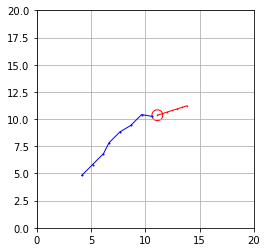

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2622756958007812
DEBUG:root:movement: 1.8836116790771484
DEBUG:root:vector 1: [0.77154446 1.        ]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.1282503112938372
DEBUG:root:movement: 1.8821773529052734
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.879765510559082
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1.        1.0000005]
DEBUG:root:angle: 0.0
DEBUG:root:movement: 1.8752360343933105
DEBUG:root:vector 1: [1.        1.0000005]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0
DEBUG:root:movement: 1.8651175498962402
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.6499178409576416
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.61844444 1.        ]
DEBUG:root:angle: 0.23152696512782583
DEBUG:root:movement: 1.7942452430725098
DEBUG:root:vector 1: [0.61844444 1.        ]


done
info {'distance_to_goal': 0.9854358, 'steps_taken': 10, 'previous_state': array([12.228675, 12.252827, 11.996011, 12.585473, 12.287006, 12.962406],
      dtype=float32), 'new_state': array([12.228675, 12.252827, 11.996011, 12.585473, 12.287006, 12.962406],
      dtype=float32)}


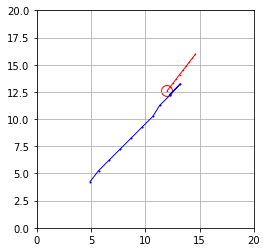

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.3675537109375
DEBUG:root:movement: 1.7812995910644531
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.         1.0000001]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.779494285583496
DEBUG:root:vector 1: [-1.         1.0000001]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.7768611907958984
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.7727956771850586
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.7660503387451172
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.753633975982666
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.268467903137207
DEBUG:root:vector

done
info {'distance_to_goal': 0.99377626, 'steps_taken': 12, 'previous_state': array([ 8.108871, 10.128074,  8.444039, 10.029729,  7.967936, 10.038824],
      dtype=float32), 'new_state': array([ 8.108871, 10.128074,  8.444039, 10.029729,  7.967936, 10.038824],
      dtype=float32)}


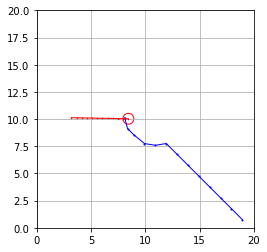

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.373025894165039
DEBUG:root:movement: 1.7971086502075195
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.7495002746582031
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.6557531356811523
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.4445164203643799
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-0.7936268 -1.       ]
DEBUG:root:angle: 0.11455599198057059
DEBUG:root:movement: 1.2067439556121826
DEBUG:root:vector 1: [-0.7936268 -1.       ]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 1.4562409211252416
DEBUG:root:movement: 0.29033565521240234
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [0.14716244 0.05373859]
DEBUG:root:angle: 1.135518770953537
DEBUG:root:movement: 1.0531315803527832
DEBUG:

done
info {'distance_to_goal': 1.4441352, 'steps_taken': 9, 'previous_state': array([11.3166065, 11.223633 , 11.562549 , 11.265021 , 11.192444 ,
       10.965388 ], dtype=float32), 'new_state': array([11.3166065, 11.223633 , 11.562549 , 11.265021 , 11.192444 ,
       10.965388 ], dtype=float32)}


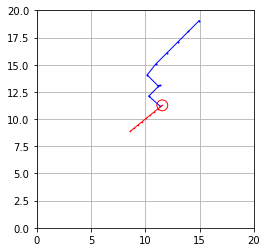

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.0501108169555664
DEBUG:root:movement: 0.8977895975112915
DEBUG:root:vector 1: [0.44088554 1.        ]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 1.200646705374057
DEBUG:root:reached goal
DEBUG:root:x: [12.950452, 13.391337, 12.391337, 12.518794]
DEBUG:root:y: [8.077157, 9.077157, 10.077157, 11.077157]
DEBUG:root:goal: [12.604936 10.761043]


done
info {'distance_to_goal': 1.0573534, 'steps_taken': 3, 'previous_state': array([12.518794, 11.077157, 12.604936, 10.761043, 13.062018, 10.894582],
      dtype=float32), 'new_state': array([12.518794, 11.077157, 12.604936, 10.761043, 13.062018, 10.894582],
      dtype=float32)}


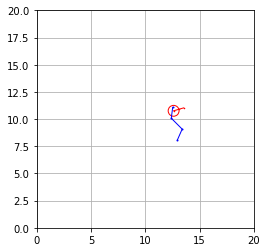

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.1818199157714844
DEBUG:root:movement: 1.6282882690429688
DEBUG:root:vector 1: [0.8168793 1.       ]
DEBUG:root:vector 2: [0.9646492 1.       ]
DEBUG:root:angle: 0.08245833678537974
DEBUG:root:movement: 1.349410057067871
DEBUG:root:vector 1: [0.9646492 1.       ]
DEBUG:root:vector 2: [-0.5898447  1.       ]
DEBUG:root:angle: 1.300325587477877
DEBUG:root:movement: 1.5900390148162842
DEBUG:root:vector 1: [-0.5898447  1.       ]
DEBUG:root:vector 2: [1. 1.]
DEBUG:root:angle: 1.318317088698795
DEBUG:root:movement: 1.369135856628418
DEBUG:root:vector 1: [1. 1.]
DEBUG:root:vector 2: [0.4345951 1.       ]
DEBUG:root:angle: 0.3754284646522005
DEBUG:root:movement: 0.8776618242263794
DEBUG:root:vector 1: [0.4345951 1.       ]
DEBUG:root:vector 2: [0.35475636 1.        ]
DEBUG:root:angle: 0.06906280509570646
DEBUG:root:movement: 0.36990731954574585
DEBUG:root:vector 1: [0.35475636 1.        ]
DEBUG:root:vector 2: [-1.        -0.6843376]
DEBUG:roo

done
info {'distance_to_goal': 0.80146164, 'steps_taken': 9, 'previous_state': array([11.417967, 12.770176, 11.008534, 12.708563, 11.1747  , 13.154821],
      dtype=float32), 'new_state': array([11.417967, 12.770176, 11.008534, 12.708563, 11.1747  , 13.154821],
      dtype=float32)}


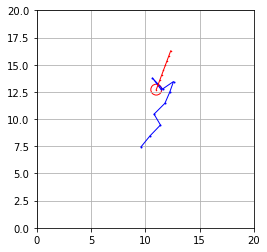

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2125473022460938
DEBUG:root:movement: 1.6125726699829102
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.5771875381469727
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.5224494934082031
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 1.4351496696472168
DEBUG:root:vector 1: [-1. -1.]
DEBUG:root:vector 2: [-1.         -0.97816086]
DEBUG:root:angle: 0.01103780462132407
DEBUG:root:movement: 1.4837141036987305
DEBUG:root:vector 1: [-1.         -0.97816086]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 1.55975660708306
DEBUG:root:movement: 1.4797673225402832
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.        -0.5934124]
DEBUG:root:angle: 1.3209598150418038
DEBUG:root:movement: 1.298710823059082
DEBU

done
info {'distance_to_goal': 1.6803107, 'steps_taken': 10, 'previous_state': array([ 7.9363422, 10.71729  ,  7.705175 , 10.488205 ,  7.239408 ,
       10.587293 ], dtype=float32), 'new_state': array([ 7.9363422, 10.71729  ,  7.705175 , 10.488205 ,  7.239408 ,
       10.587293 ], dtype=float32)}


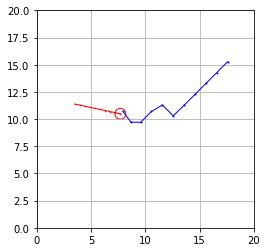

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 0.9958734512329102
DEBUG:root:movement: 1.2775425910949707
DEBUG:root:vector 1: [ 1.        -0.2913208]
DEBUG:root:vector 2: [1.0000005 0.6498709]
DEBUG:root:angle: 0.8597596453558922
DEBUG:root:movement: 1.3373069763183594
DEBUG:root:vector 1: [1.0000005 0.6498709]
DEBUG:root:vector 2: [ 1.         -0.56010246]
DEBUG:root:angle: 1.086850571524199
DEBUG:root:movement: 1.2842590808868408
DEBUG:root:vector 1: [ 1.         -0.56010246]
DEBUG:root:vector 2: [ 1.         -0.22170734]
DEBUG:root:angle: 0.2923878479104494
DEBUG:root:movement: 1.1117968559265137
DEBUG:root:vector 1: [ 1.         -0.22170734]
DEBUG:root:vector 2: [1.         0.04135036]
DEBUG:root:angle: 0.25950462822164727
DEBUG:root:movement: 1.3073017597198486
DEBUG:root:vector 1: [1.         0.04135036]
DEBUG:root:vector 2: [ 1.        -0.7672806]
DEBUG:root:angle: 0.6957959665997031
DEBUG:root:reached goal
DEBUG:root:x: [6.2053313, 7.2053313, 8.205332, 9.205332, 10.205332, 

done
info {'distance_to_goal': 0.86756945, 'steps_taken': 7, 'previous_state': array([12.296893, 12.685221, 12.457188, 12.68304 , 12.7788  , 13.034213],
      dtype=float32), 'new_state': array([12.296893, 12.685221, 12.457188, 12.68304 , 12.7788  , 13.034213],
      dtype=float32)}


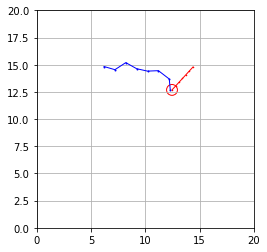

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.3582463264465332
DEBUG:root:movement: 0.9498200416564941
DEBUG:root:vector 1: [ 0.9999999 -1.       ]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0
DEBUG:root:movement: 0.9425563812255859
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.9294698238372803
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.9024579524993896
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.7301044464111328
DEBUG:root:vector 1: [ 1. -1.]
DEBUG:root:vector 2: [ 1.        -0.3671236]
DEBUG:root:angle: 0.43355074074753425
DEBUG:root:movement: 0.8586040735244751
DEBUG:root:vector 1: [ 1.        -0.3671236]
DEBUG:root:vector 2: [ 1.0000005  -0.84857845]
DEBUG:root:angle: 0.35182044753859837
DEBUG:root:reached goal
DEBUG:root:x: [1.76

done
info {'distance_to_goal': 1.0388244, 'steps_taken': 8, 'previous_state': array([ 9.763685 , 10.305549 , 10.013233 ,  9.975754 ,  9.785106 ,
       10.3937435], dtype=float32), 'new_state': array([ 9.763685 , 10.305549 , 10.013233 ,  9.975754 ,  9.785106 ,
       10.3937435], dtype=float32)}


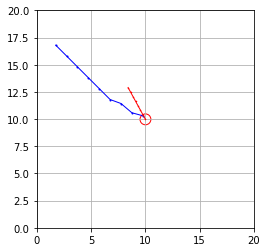

DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 0.9849667549133301
DEBUG:root:movement: 1.5462415218353271
DEBUG:root:vector 1: [0.9652195  0.21143627]
DEBUG:root:vector 2: [1.        0.5353222]
DEBUG:root:angle: 0.2758555061006775
DEBUG:root:movement: 1.5167531967163086
DEBUG:root:vector 1: [1.        0.5353222]
DEBUG:root:vector 2: [0.9542055 0.9548521]
DEBUG:root:angle: 0.29423233521684816
DEBUG:root:movement: -0.8272087574005127
DEBUG:root:vector 1: [0.9542055 0.9548521]
DEBUG:root:vector 2: [-0.9082041  0.9985447]
DEBUG:root:angle: 1.523113677295573
DEBUG:root:movement: -0.19785428047180176
DEBUG:root:vector 1: [-0.9082041  0.9985447]
DEBUG:root:vector 2: [0.9487438 0.865345 ]
DEBUG:root:angle: 1.5693928753682913
DEBUG:root:movement: 0.9906135201454163
DEBUG:root:vector 1: [0.9487438 0.865345 ]
DEBUG:root:vector 2: [-0.21445751 -1.        ]
DEBUG:root:angle: 2.5215115489626503
DEBUG:root:movement: -0.8707155585289001
DEBUG:root:vector 1: [-0.21445751 -1.        ]
DEBUG:root:vect

done
info {'distance_to_goal': 0.837183, 'steps_taken': 10, 'previous_state': array([12.811503,  9.377812, 12.558252,  9.663201, 13.030369,  9.601047],
      dtype=float32), 'new_state': array([12.811503,  9.377812, 12.558252,  9.663201, 13.030369,  9.601047],
      dtype=float32)}


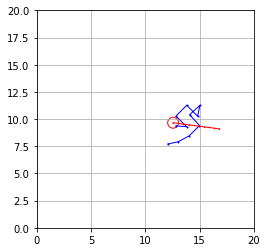

In [5]:

# test prediction
logger.setLevel(logging.DEBUG)

episodes = 10
for episode in range(episodes):
    env.reset()

    while True:
        action, _states = model.predict(env.state)
        obs, rewards, done, info = env.step(action)
        if done:
            print('done')
            print("info", info)
            break
    env.render()

In [6]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model, env, n_eval_episodes=10, render=False)

# TODO render doesn't work

/home/luttkule/anaconda3/envs/rl-test/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.365138292312622
DEBUG:root:movement: 0.9925427436828613
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 0.9649845361709595
DEBUG:root:vector 1: [-1.  1.]
DEBUG:root:vector 2: [-1.  1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:reached goal
DEBUG:root:
DEBUG:root:reset
DEBUG:root:movement: 1.2967567443847656
DEBUG:root:movement: 1.7515506744384766
DEBUG:root:vector 1: [ 0.99999994 -1.        ]
DEBUG:root:vector 2: [ 1. -1.]
DEBUG:root:angle: 0.0003452669847162036
DEBUG:root:movement: 

(1122.3294204235076, 131.20227888547666)